In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import layers, Model, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
X, y = df.drop(['Class'], axis=1), df['Class']

x_tr_scaler = MinMaxScaler()
y_tr_scaler = MinMaxScaler()
x_ts_scaler = MinMaxScaler()
y_ts_scaler = MinMaxScaler()

X = np.array(X)
y = np.array(y).reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

x_train_scaled = x_tr_scaler.fit_transform(x_train)
x_test_scaled = x_ts_scaler.fit_transform(x_test)
y_train_scaled = y_tr_scaler.fit_transform(y_train)
y_test_scaled = y_ts_scaler.fit_transform(y_test)

In [5]:
print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train_scaled.shape)
print(y_test_scaled.shape)

(256326, 30)
(28481, 30)
(256326, 1)
(28481, 1)


In [6]:
input = Input(shape=x_train.shape[1])
Dense1 = layers.Dense(128, activation='relu')(input)
Dense2 = layers.Dense(64, activation='relu')(Dense1)
Dense3 = layers.Dense(16, activation='relu')(Dense2)
output = layers.Dense(1, activation='sigmoid')(Dense3)
model = Model(inputs=input, outputs=output)

In [7]:
best_model_filepath = 'best_model.h5'

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mc = ModelCheckpoint(best_model_filepath, monitor='val_loss', mode='min', save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 13,281
Trainable params: 13,281
Non-trainable params: 0
_________________________________________________________________


In [8]:
EPOCHS = 10
history = model.fit(x_train_scaled,
                    y_train_scaled,
                    shuffle=True,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    callbacks=[es, mc],
                    verbose='auto')

Epoch 1/10
6409/6409 [==============================] - 14s 2ms/step - loss: 0.0072 - accuracy: 0.9989 - val_loss: 0.0034 - val_accuracy: 0.9994
Epoch 2/10
6409/6409 [==============================] - 13s 2ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.0034 - val_accuracy: 0.9994
Epoch 3/10
6409/6409 [==============================] - 13s 2ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.0041 - val_accuracy: 0.9993
Epoch 4/10
6409/6409 [==============================] - 15s 2ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 0.0039 - val_accuracy: 0.9994
Epoch 5/10
6409/6409 [==============================] - 18s 3ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.0034 - val_accuracy: 0.9994


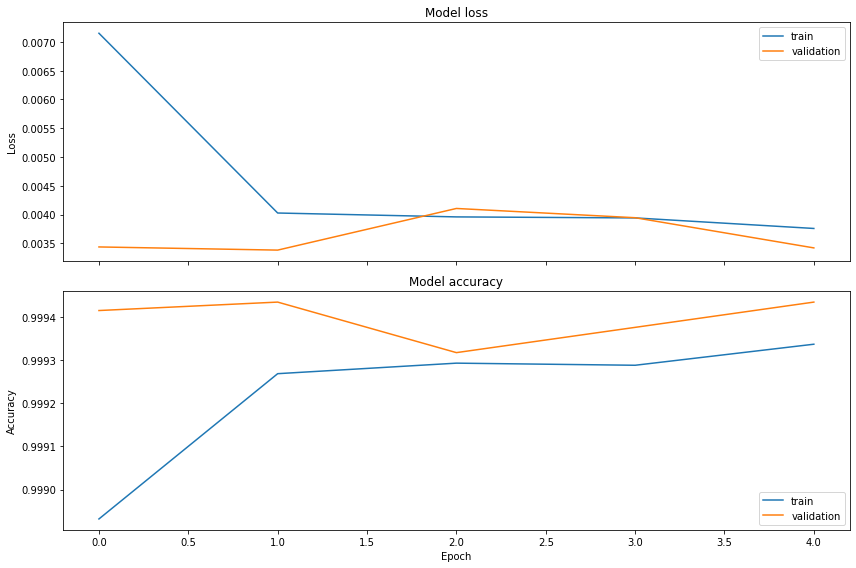

In [9]:
figure, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(24, 16))

df_loss_accuracy = pd.DataFrame(history.history)
df_loss = df_loss_accuracy[['loss','val_loss']].copy(deep=True)
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_accuracy = df_loss_accuracy[['accuracy','val_accuracy']].copy(deep=True)
df_accuracy.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)

df_loss.plot(ax=ax1, title='Model loss', figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_accuracy.plot(ax=ax2, title='Model accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

figure.tight_layout()

In [13]:
# model_json = model.to_json()
# with open('model.json', 'w') as json_file:
#     json_file.write(model_json)
# model.save_weights('model_weights.h5')